In [1]:
import warnings                                  # `do not disturb`
warnings.filterwarnings('ignore')
import time

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import pickle
%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error # Importing metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def moving_average(series, n=15):
    """
    Calculate average of last n observations
    """
    return np.average(series[-n:])

def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    values = series.values
    result = [values[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * values[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas, plot_intervals = False, scale = 1.96, plot_anomalies=False):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """  
    plt.figure(figsize=(15, 5))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), c="orange", label="Alpha {}".format(alpha))
    plt.plot(series.values, "b", label = "Actual")
    plt.title("Moving Exponential Average\n Alpha = {}".format(alphas))
    plt.legend(loc="best")
    plt.axis('tight')
    
    if plot_intervals:
        mae = mean_absolute_error(
            series, exponential_smoothing(series, alpha)
        )
        
        deviation = np.std(series - exponential_smoothing(series, alpha))
        lower_bound = exponential_smoothing(series, alpha) - (mae + scale * deviation)
        upper_bound = exponential_smoothing(series, alpha) + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" lower-bound anomalies found"))
            anomalies[series>upper_bound] = series[series>upper_bound]
            print(str(len(anomalies[series<lower_bound])) + str(" upper-bound anomalies found"))
            plt.plot(anomalies, "black", markersize=10)
        
    plt.legend(loc="best")
    plt.grid(b=True)
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    
    with plt.style.context(style):   
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [3]:
# Bring in datasets
data_folder = "/Users/dominguez/Documents/Kaggle_G_Research_Crypto/data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
example_test = pd.read_csv(data_folder + 'example_test.csv')
example_sample_submission = pd.read_csv(data_folder + "example_sample_submission.csv")

# Prep submission file
submission = example_sample_submission[["group_num", "row_id"]]
submission["Asset_ID"] = example_test["Asset_ID"]
submission["Target"] = np.nan

In [9]:
%%time
n_steps_to_train = 500
n_steps_to_plot = 100 # Make sure plot is easy on the eyes
n_steps_to_predict = 3
p = 2
d = 0
q = 13
alpha = 0.005
models = dict()
errors = dict()
forecasts = dict()

for i in range(len(asset_details)):
    current_id = asset_details.Asset_ID[i]
    current_asset_name = asset_details.Asset_Name[i]
    suffix = "_train.pickle"
    
    # Load individual dataset
    with open(data_folder + current_asset_name + suffix, "rb") as f:
        current_dataset = pickle.load(f)
    
    # Calculate exponential smoothing
    current_dataset_mini = current_dataset.copy()[-n_steps_to_train:]
    current_dataset_mini["Smoothed"] = exponential_smoothing(current_dataset_mini.Target, alpha=alpha)
    data = current_dataset_mini["Smoothed"]
    
    # Train our model
    model = statsmodels.tsa.arima.model.ARIMA(endog=data.values, exog=None, order=(p,d,q)).fit() 
    aic = model.aic
    print(f"{current_asset_name}, {current_id} AIC: {aic}")
    
    # Forecasting
    actual = np.array(data.values)
    arima_model = np.array(model.fittedvalues)
    forecast = list(model.predict(start = len(actual), end = len(actual)+n_steps_to_predict))
    forecast = list(arima_model) + forecast
    
    # Save feedback
    forecasts[current_id] = forecast
    models[current_id] = model
    errors[current_id] = mean_absolute_percentage_error(actual, arima_model)
    
    # Save model
    with open(f"./models/{current_id}.pickle", "wb") as f:
        pickle.dump(model, f, protocol=4)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Bitcoin_Cash, 2 AIC: -10743.522154153916


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Binance_Coin, 0 AIC: -9960.807512548357


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Bitcoin, 1 AIC: -11148.850254639716


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


EOS, 5 AIC: -10591.962829530814


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Ethereum_Classic, 7 AIC: -10644.17690269151


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Ethereum, 6 AIC: -10966.420176374218


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Litecoin, 9 AIC: -10689.921225128068


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Monero, 11 AIC: -9828.72599542237
TRON, 13 AIC: -10078.671708775346


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Stellar, 12 AIC: -10562.036498755735


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Cardano, 3 AIC: -10542.921486579085


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


IOTA, 8 AIC: -9039.892270239267


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Maker, 10 AIC: -9766.56047083699
Dogecoin, 4 AIC: -10573.704907689324
CPU times: user 30.7 s, sys: 3.35 s, total: 34 s
Wall time: 27.1 s


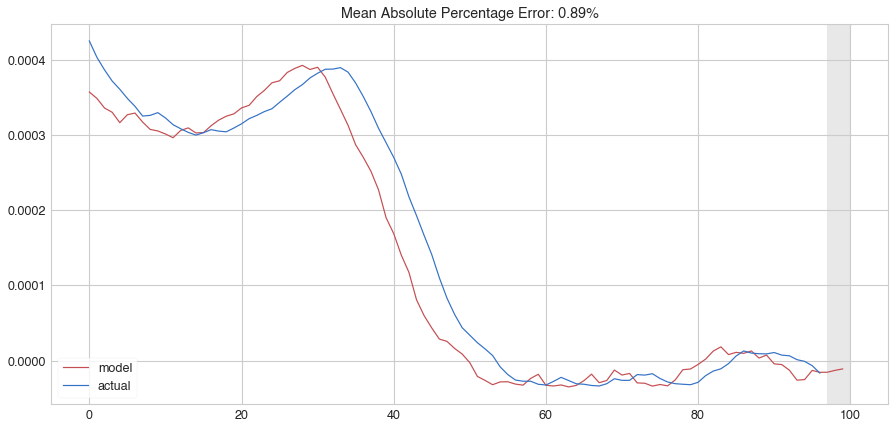

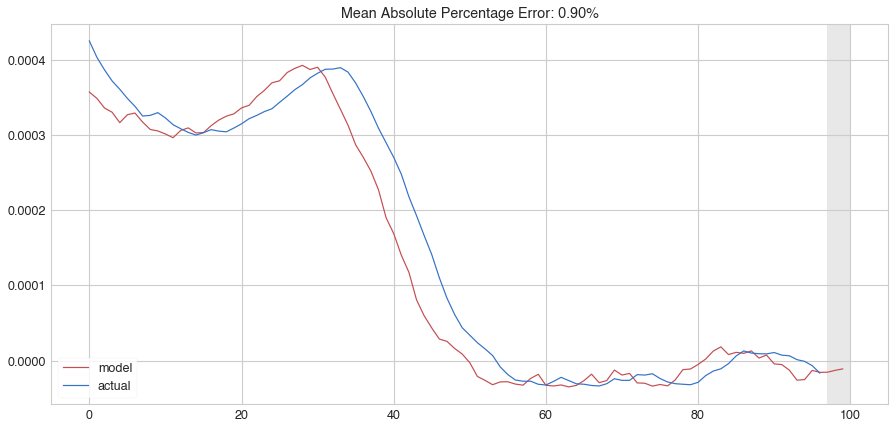

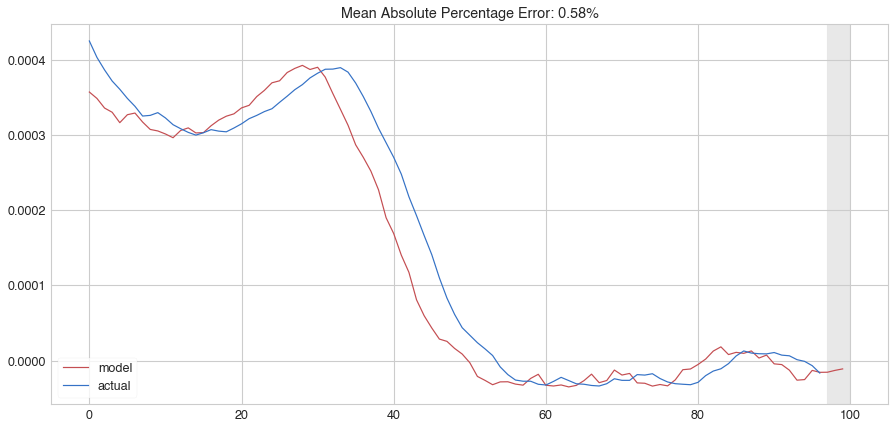

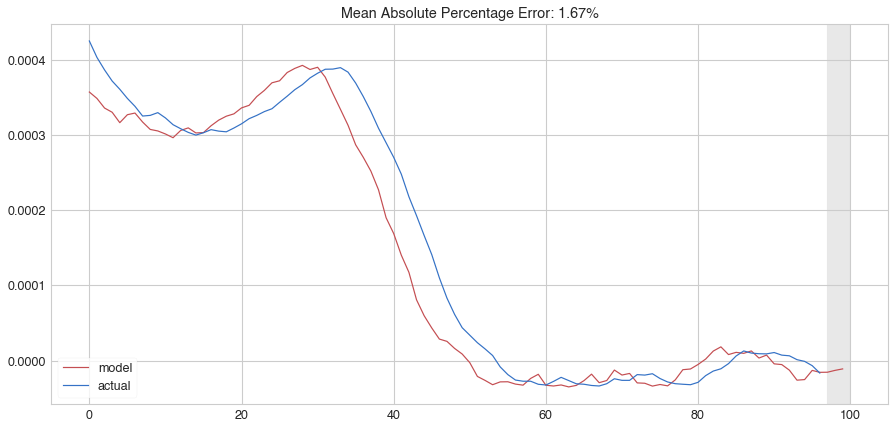

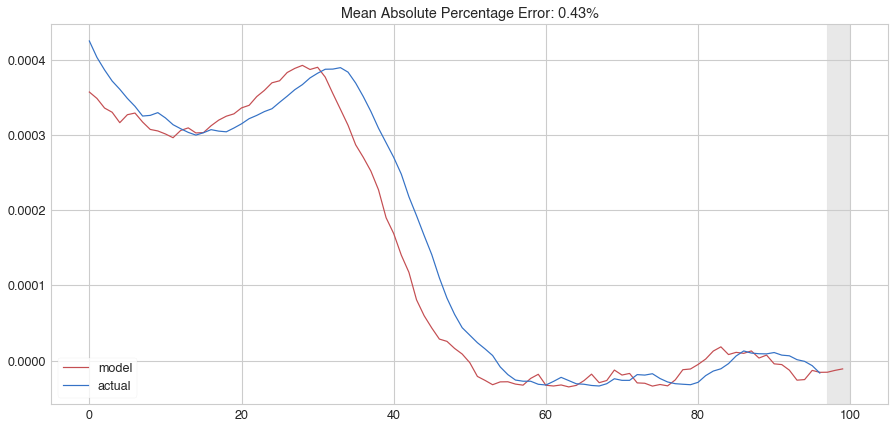

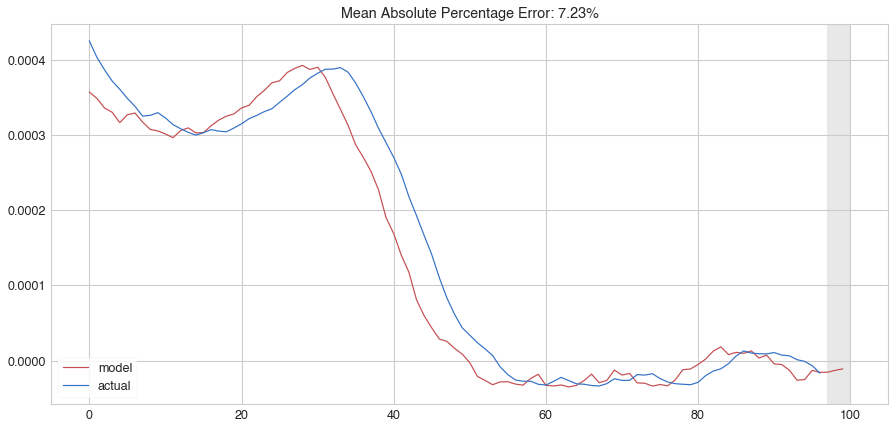

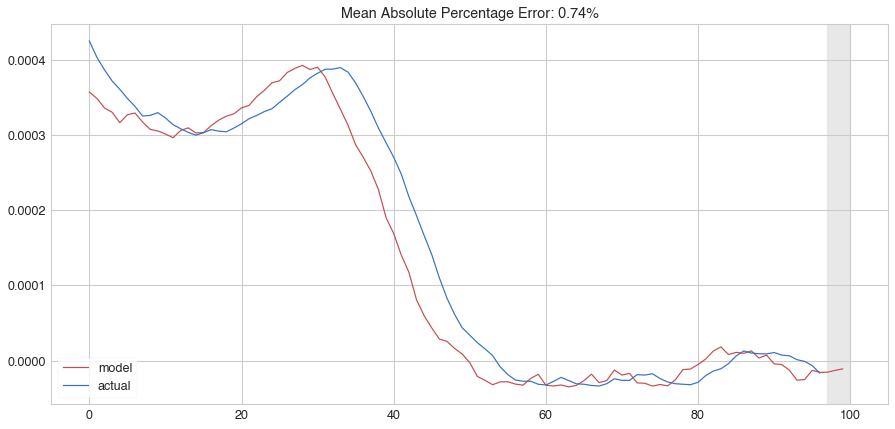

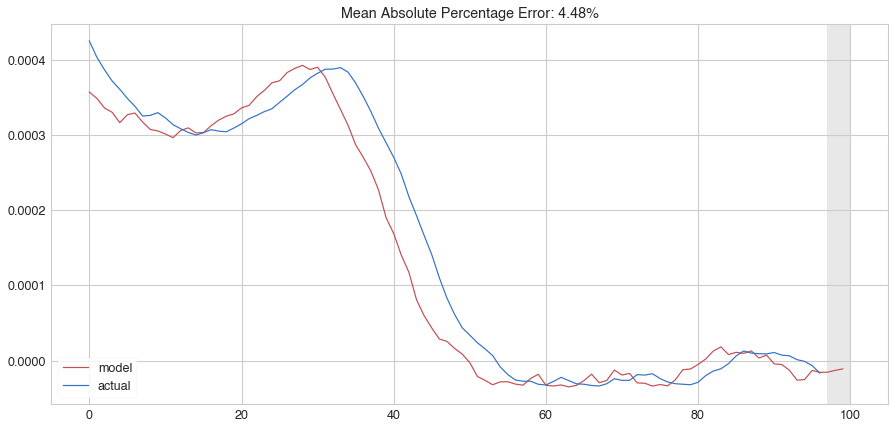

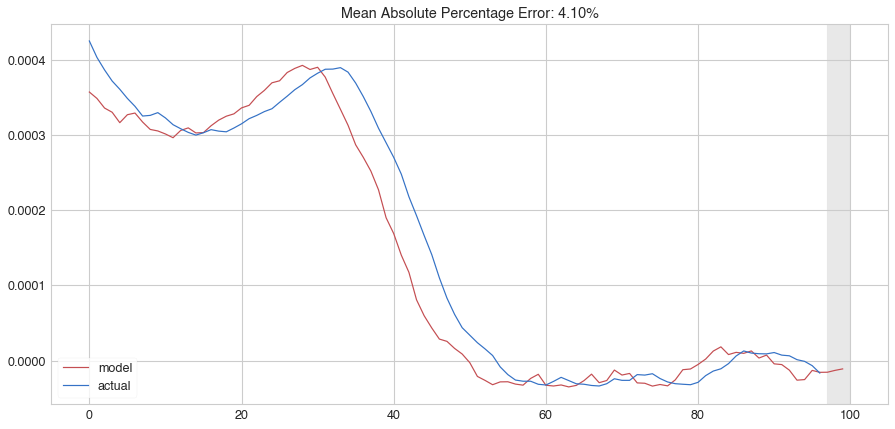

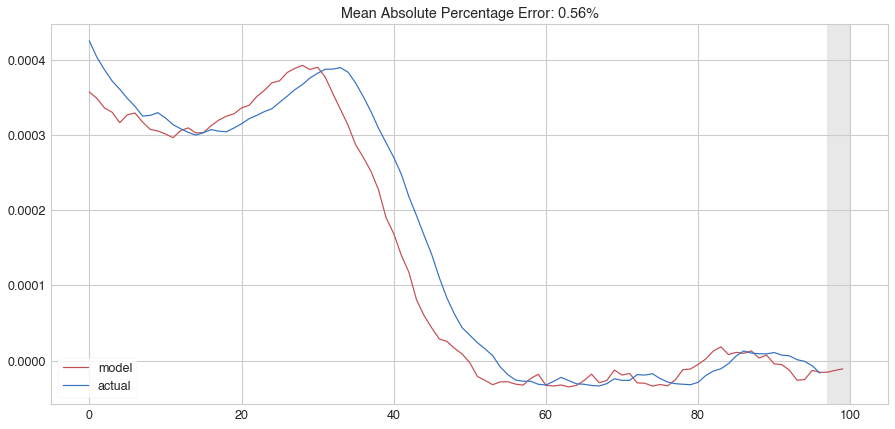

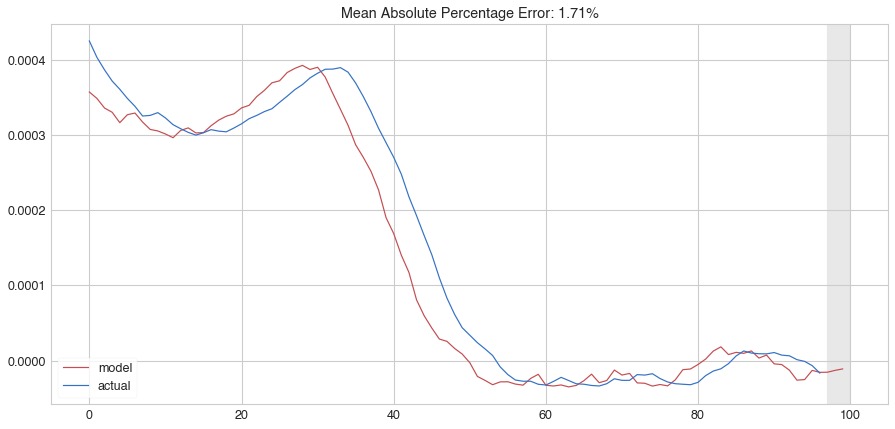

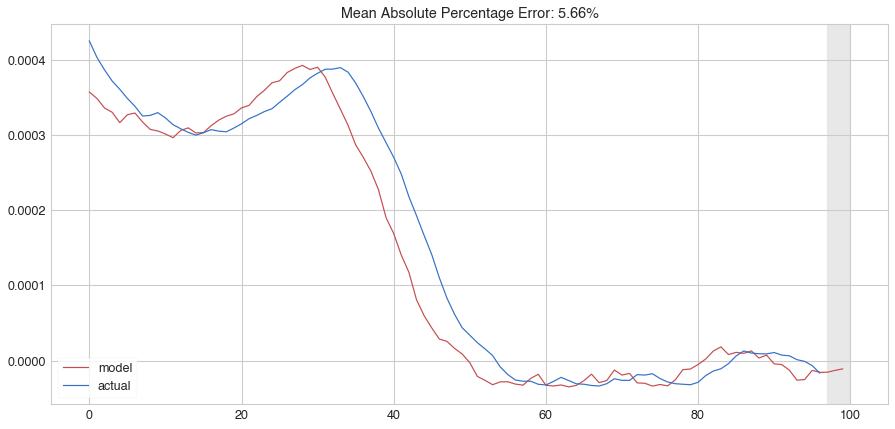

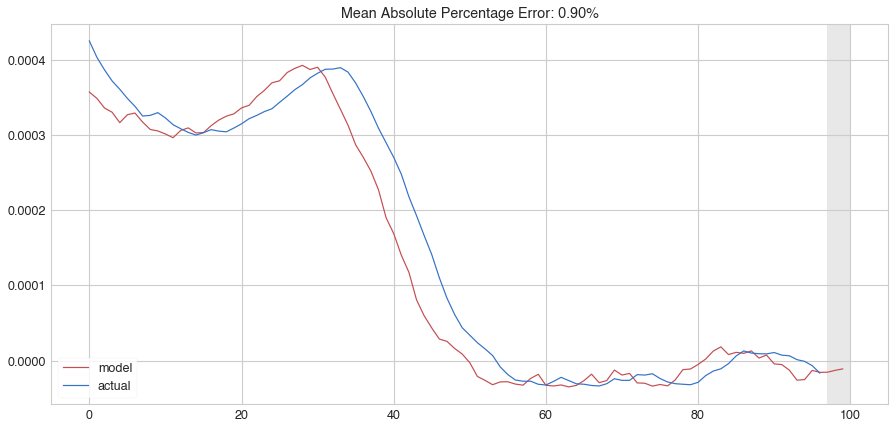

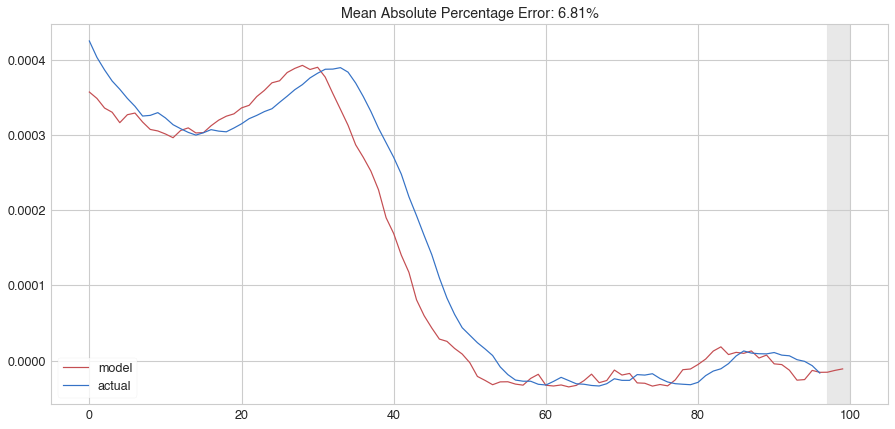

In [10]:
for error in list(errors.values()):
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast[-n_steps_to_plot:], color='r', label="model")
    plt.axvspan(len(forecast[-n_steps_to_plot:])-n_steps_to_predict, len(forecast[-n_steps_to_plot:]), alpha=0.5, color='lightgrey')
    plt.plot(actual[-n_steps_to_plot:-n_steps_to_predict], label="actual")
    plt.legend()
    plt.grid(True);

In [5]:
# with open("./models/errors.pickle", "wb") as f:
#     pickle.dump(errors, f)
    
# with open("./models/models.pickle", "wb") as f:
#     pickle.dump(models, f)

# with open("./models/forecasts.pickle", "wb") as f:
#     pickle.dump(forecasts, f)

# with open("./models/errors.pickle", 'rb') as f:
#     errors = pickle.load(f)
    
# with open("./models/models.pickle", 'rb') as f:
#     models = pickle.load(f)
    
# with open("./models/forecasts.pickle", 'rb') as f:
#     forecasts = pickle.load(f)

In [ ]:
# Iterate through the Asset_IDs and input the corresponding predicted target
# Drop Asset_ID column (it should be ready for submission at this point)

In [15]:
# Get our forecasts in the correct order as required by Kaggle submission rules
y_preds_for_submission = []
for i in range(len(submission.group_num)):
    current_id = submission.Asset_ID[i]
    current_prediction = forecasts[current_id][submission.group_num[i]]
    y_preds_for_submission.append(current_prediction)

assert len(y_preds_for_submission) == 56, "There needs to be 56 predictions for submission"

In [16]:
submission.Target = y_preds_for_submission
submission.drop("Asset_ID", axis="columns", inplace=True)

In [17]:
submission.to_csv("./data/my_submission.csv", index=False)